## Import Libraries

In [56]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [57]:
df = pd.read_csv("./Lower player.csv")

In [58]:
df.shape

(5912, 19)

In [59]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,2,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000


In [60]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [61]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [62]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [63]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [64]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [65]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2255
Cheap_Price    1946
High_Price     1711
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [66]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,22000000,High_Price
1,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,6000000,Good_Price


In [67]:
categorical_col = ['team' , 'position']

In [68]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [69]:
df.shape

(5912, 403)

In [70]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [71]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.381909
minutes played         0.306681
appearance             0.305590
games_injured          0.233946
                         ...   
position_Defender     -0.090184
position_Attack       -0.115159
position_midfield     -0.133761
goals conceded        -0.143927
position_Goalkeeper   -0.209644
Name: sale_price_category, Length: 403, dtype: float64

In [72]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['age', 'appearance', 'assists', 'goals conceded', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'sale_price_category', 'position_Attack', 'position_Goalkeeper',
       'position_midfield'],
      dtype='object')

In [73]:
df = df[selected_features]

#### 4. Prepare train and test data

In [74]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
X.shape

(5912, 12)

## Buliding the Model

In [76]:
model = KNeighborsClassifier()

In [77]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [78]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [79]:
grid_search.best_params_

{'n_neighbors': 7}

In [80]:
model = grid_search.best_estimator_

## Test the Model

In [81]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [82]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

38.14

1. Accuracy

In [83]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train accuracy' ,accuracy_train*100)


Test accuracy 63.229078613694
Train accuracy 73.63078875026433


2. Precision

In [84]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print(f"Test Precision: {precision_test:.2f}")

y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train,average='macro')
print(f"Train Precision: {precision_train:.2f}")

Test Precision: 0.66
Train Precision: 0.76


3. Recall

In [85]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print(f"Test Recall: {recall_test:.2f}")

y_pred_train = model.predict(X_train_scaled)
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Train Recall: {recall_train:.2f}")

Test Recall: 0.63
Train Recall: 0.73


4. F1 Score

In [86]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_test:.2f}")

y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"Train F1 Score: {f1_train:.2f}")

Test F1 Score: 0.64
Train F1 Score: 0.74


#### Predictions vs. Real Values

In [87]:
predictions = model.predict(X_test)

In [88]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

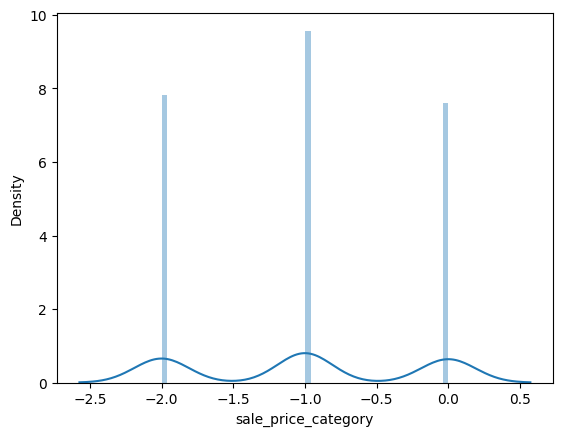

In [89]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[270, 117,   1],
       [115, 282,  52],
       [ 33, 117, 196]], dtype=int64)